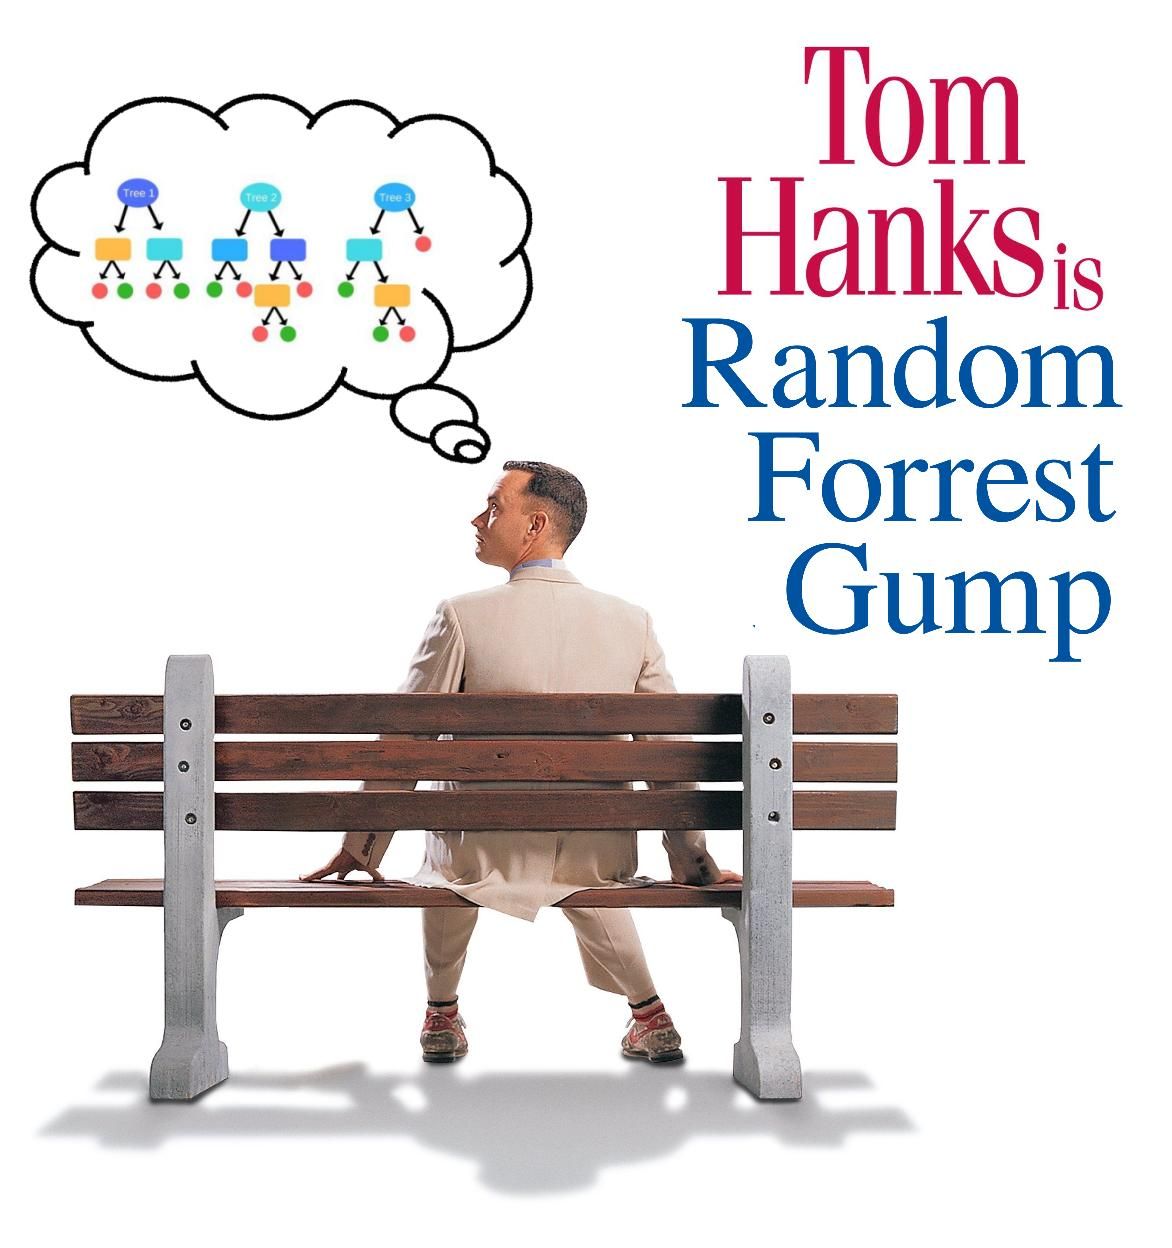

In [1]:
from IPython.display import Image
Image("portada.jpg")

# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



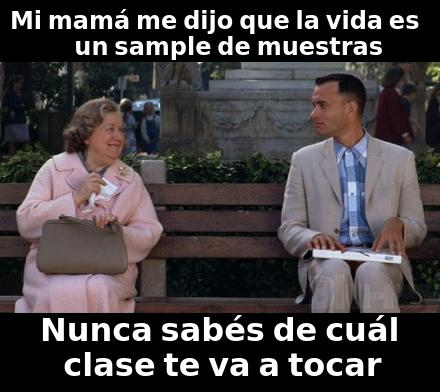

In [2]:
from IPython.display import Image
Image("chocolates.jpg")

In [3]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm

import sklearn.model_selection
from scipy.stats import randint as sp_randint

In [4]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 

X_competencia = pd.read_csv("X_competencia1.csv", index_col="index")
y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")
display(X)
display(y)

# Descomentar si quieren ver los datos para la competencia:
display(X_competencia) 
display(y_competencia_ejemplo)


X_competencia.describe()

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.2516,0.9375,-1.1980,0.4577,0.9287,0.5373,0.2476,...,0.5829,-0.5494,0.4607,1.2182,0.1025,3.0034,-0.0344
496,0.6246,-1.0590,0.9491,0.2687,0.6610,-1.6657,0.3982,...,-0.1075,0.8993,-0.4229,0.3977,-0.0808,-1.7054,-0.4786
497,0.2677,0.1802,0.7154,0.3542,-0.9023,-1.7792,-0.0121,...,0.8491,0.7469,0.2071,-1.0090,0.3317,-1.7513,-0.5397


,output
index,
0,0
1,0
2,0
3,0
4,1
...,...
495,1
496,0
497,1


,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
501,0.2828,2.0610,1.0889,-0.7976,0.6819,-0.0531,0.3860,...,0.6734,0.3584,1.0187,1.4373,-0.7069,0.9051,-0.5420
502,-1.1895,1.1622,0.4257,0.7102,0.2699,1.1044,1.7634,...,-2.1822,0.0875,-0.6501,-1.7537,0.6584,-0.4861,-0.6913
503,-0.2730,-0.2018,0.4408,-1.0598,-0.3892,2.5573,0.1915,...,2.5449,-1.1552,1.0447,-0.6057,-2.2056,-0.4326,-0.2387
504,0.2006,0.5208,0.0377,-0.0886,1.5035,-1.6581,-1.1057,...,-1.7424,-0.5942,0.0929,0.4501,1.7539,-0.3211,2.0208
505,-0.6236,-1.2563,-0.4989,-2.3673,0.6763,-1.3346,0.9431,...,-0.5637,0.5153,0.2446,2.4462,0.3621,-0.2002,0.2214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.1862,-0.4901,0.4467,0.0266,-0.4089,0.6472,0.3563,...,-0.4666,-1.9118,-0.0137,-0.5356,-1.5728,1.0976,-0.1557
4996,0.3290,-0.1691,-1.0451,-1.1327,-0.7251,1.8375,1.0902,...,1.2854,-1.6045,0.1122,-0.4087,0.8175,-0.2249,0.6526
4997,-1.6937,-0.1262,-0.3666,-0.5854,0.1751,0.0770,0.0218,...,-0.4626,-1.1507,-0.1373,-0.7572,0.4323,-1.0987,-1.2257


,output
index,
501,0.9122
502,0.4295
503,0.6675
504,0.8060
505,0.0661
...,...
4995,0.4022
4996,0.0091
4997,0.2368


,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
count,4499.0000,4499.0000,4499.0000,4499.0000,4499.0000,4499.0000,4499.0000,...,4499.0000,4499.0000,4499.0000,4499.0000,4499.0000,4499.0000,4499.0000
mean,-0.0148,0.0082,-0.0019,0.0092,-0.0055,0.0071,-0.0106,...,0.0045,0.0142,-0.0112,-0.0043,0.0192,0.0060,-0.0160
std,1.0191,0.9992,1.0000,1.0080,0.9973,0.9926,0.9875,...,1.0079,1.0035,0.9993,0.9958,1.0041,1.0000,0.9930
min,-3.6533,-3.6325,-3.3637,-3.5548,-3.2302,-3.3062,-3.4344,...,-3.4429,-3.5572,-3.8216,-3.6234,-3.6098,-3.4736,-4.1283
25%,-0.7011,-0.6602,-0.6785,-0.6559,-0.6703,-0.6686,-0.6671,...,-0.6816,-0.6415,-0.6925,-0.6693,-0.6555,-0.6539,-0.6520
50%,-0.0066,0.0072,0.0028,-0.0024,-0.0194,-0.0009,-0.0162,...,-0.0029,0.0369,-0.0252,-0.0131,0.0319,0.0008,-0.0158
75%,0.6728,0.6827,0.6602,0.6818,0.6474,0.6871,0.6593,...,0.6630,0.6765,0.6665,0.6777,0.6791,0.6611,0.6455
max,4.0339,3.9616,3.7862,4.0113,3.8407,3.5262,3.3133,...,3.7768,3.8693,3.6974,3.4109,3.9651,3.5566,3.7533


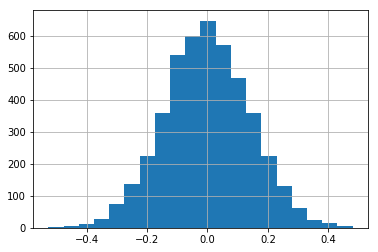

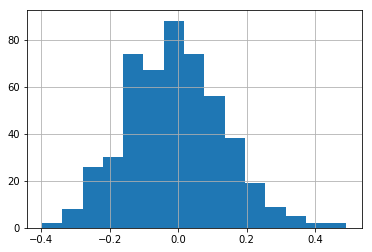

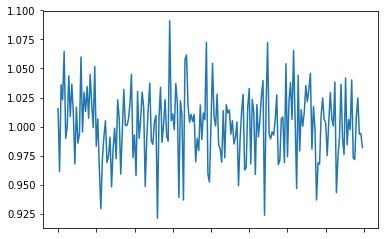

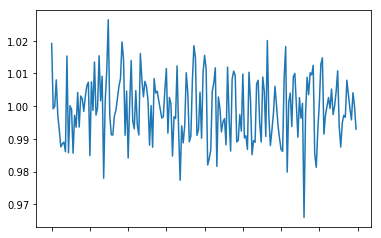

In [5]:
#Analisis de los datos
## Compararemos algunas medidas de los datos con los de la competencia para ver que se 
## parezcan lo mas posible, de esta manera forzar un overfitting con los datos de la competencia

X_competencia.mean(axis=1).hist(bins=20)
plt.show()
X.mean(axis=1).hist(bins=15)
plt.show()
X.std().plot()
plt.show()
X_competencia.std().plot()


## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. 

X_dev: (375, 200), y_dev: (375, 1) para desarrollo
X_eval: (125, 200), y_eval: (125, 1) para evaluación


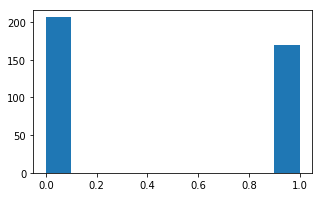

,output,%
output,,
0,271,0.542
1,229,0.458


,output,%
output,,
0,206,0.5493
1,169,0.4507


,output,%
output,,
0,65,0.52
1,60,0.48


In [6]:
# EJERCICIO 1. 

np.random.seed(1234)


########################################################
## AQUI VA SU CODIGO
X_dev, X_eval, y_dev, y_eval = sklearn.model_selection.train_test_split(X, y, test_size=0.25)# cambiar esta línea si lo consideran necesario

# Objetivo: variables X_dev, X_eval, y_dev e y_eval asignadas
#########################################################


print("X_dev: {}, y_dev: {} para desarrollo".format(X_dev.shape, y_dev.shape))
print("X_eval: {}, y_eval: {} para evaluación".format(X_eval.shape, y_eval.shape))

plt.figure(figsize=(5, 3))
plt.hist(np.array(y_dev))  # muestra un histograma para la distribución de y.
plt.show()


def porcentajes(df,columna):
    d = df.groupby(columna).agg({columna:"count"})
    d['%'] = d[columna]/d[columna].sum()
    return d

display(porcentajes(y,"output"))
display(porcentajes(y_dev,"output"))
display(porcentajes(y_eval,"output"))


#X_dev.plot(use_index=True, kind="hist")
#X_competencia.mean().plot()
#plt.show()

#X_dev.std().plot()
#X_competencia.std().plot()

## Ejercicio 1

Elegimos dividir los datos de manera **aleatoria** para no introducir ningun tipo de desbalanceo entre ellos. Como no podemos asumir que tenemos ningún tipo de división en los datos, como temporalidad, decidimos hacer una división arbitraria con lo provisto por sklearn

## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   **

----

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.8367,0.6667,0.8739,0.6721
2,0.8167,0.6800,0.8807,0.6646
3,0.8633,0.6667,0.8895,0.6900
4,0.8300,0.7200,0.8438,0.7742
5,0.8433,0.7067,0.9052,0.6964


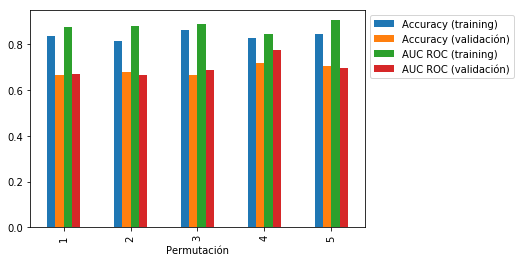

In [7]:
accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

# Puede serles de utilidad tener a X_dev e y_dev como matrices de numpy directamente:
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

########################################################
## AQUI VA SU CODIGO 
## Objetivo: accuracies_training, accuracies_validation, aucs_training y aucs_validation asignados
#########################################################
arbol = sklearn.tree.DecisionTreeClassifier(max_depth=3)
kf = sklearn.model_selection.KFold(n_splits=5)



for train_index, test_index in kf.split(X_dev_np,y_dev_np):
    X_train, X_test = X_dev_np[train_index], X_dev_np[test_index]
    y_train, y_test = y_dev_np[train_index], y_dev_np[test_index]
    
    arbol.fit(X_train, y_train)
    y_pred_train = arbol.predict(X_train)
    y_pred_test = arbol.predict(X_test)
    
    y_pred_proba_train = [y[1] for y in arbol.predict_proba(X_train)]
    y_pred_proba_test = [y[1] for y in arbol.predict_proba(X_test)]
    
    sc_train = arbol.score(X_train, y_train)
    accuracies_training.append(sc_train)
    
    sc_test = arbol.score(X_test, y_test)
    accuracies_validation.append(sc_test)
    
    auc_train = sklearn.metrics.roc_auc_score(y_train, y_pred_proba_train)
    aucs_training.append(auc_train)
    
    auc_test = sklearn.metrics.roc_auc_score(y_test, y_pred_proba_test)
    aucs_validation.append(auc_test)
  
df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
df["Accuracy (training)"] = accuracies_training
df["Accuracy (validación)"] = accuracies_validation
df["AUC ROC (training)"] = aucs_training
df["AUC ROC (validación)"] = aucs_validation


display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

In [8]:
resultados_training = []
resultados_validation = []

########################################################
## AQUI VA SU CODIGO 
## Objetivo: resultados_training y resultados_validation asignadas
#
## Recomendamos seguir el siguiente esquema:
# np.random.seed(SEED)
# for criterio in ["gini", "entropy"]:
#     for altura in [3, 5, None]:
#         CODIGO AQUI.
#         resultados_training.append( <RESULTADO_TRAINING> )
#         resultados_validation.append( <RESULTADO_VALIDATION> )
#########################################################

np.random.seed(SEED)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_dev, y_dev, test_size=0.2)

for criterio in ["gini", "entropy"]:
    for altura in [3, 5, None]:
        arbol = sklearn.tree.DecisionTreeClassifier(max_depth=altura,criterion=criterio)
        arbol.fit(X_train, y_train)
        y_pred_train = arbol.predict(X_train)
        y_pred_test = arbol.predict(X_test)
        
        y_pred_proba_train = [y[1] for y in arbol.predict_proba(X_train)]
        y_pred_proba_test = [y[1] for y in arbol.predict_proba(X_test)]
        
        auc_train = sklearn.metrics.roc_auc_score(y_train, y_pred_proba_train)
        resultados_training.append(auc_train)
    
        auc_test = sklearn.metrics.roc_auc_score(y_test, y_pred_proba_test)
        resultados_validation.append(auc_test)


df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"] = resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation

   
display(HTML("<h3> TABLA 2 </h3>"))
display(df)

,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.8896,0.6789
1,5,Gini,0.9849,0.6554
2,Inifinito,Gini,1.0000,0.5821
3,3,Ganancia de Información,0.8930,0.6739
4,5,Ganancia de Información,0.9963,0.6686
5,Inifinito,Ganancia de Información,1.0000,0.6464


In [9]:
# EJERCICIO EXTRA

from notebook_4_implementacion_arboles import MiClasificadorArbol

def ejercicioExtra():
    accuracies_training = []
    accuracies_validation = []
    aucs_training = []
    aucs_validation = []

    X_dev_np = np.array(X_dev)
    y_dev_np = np.array(y_dev).ravel()

    arbol = MiClasificadorArbol(list(range(X_dev_np.shape[1])),3, "gini")
    kf = sklearn.model_selection.KFold(n_splits=5)
    
    for train_index, test_index in kf.split(X_dev_np,y_dev_np):
        X_train, X_test = X_dev_np[train_index], X_dev_np[test_index]
        y_train, y_test = y_dev_np[train_index], y_dev_np[test_index]
        
        arbol.fit(X_train, y_train)
        
        sc_train = arbol.score(X_train, y_train)
        accuracies_training.append(sc_train)
        
        sc_test = arbol.score(X_test, y_test)
        accuracies_validation.append(sc_test)
        
        y_pred_proba_train = [y[1] for y in arbol.predict_proba(X_train)]
        y_pred_proba_test = [y[1] for y in arbol.predict_proba(X_test)]
        
        auc_train = sklearn.metrics.roc_auc_score(y_train, y_pred_proba_train)
        aucs_training.append(auc_train)
    
        auc_test = sklearn.metrics.roc_auc_score(y_test, y_pred_proba_test)
        aucs_validation.append(auc_test)
        
    df = pd.DataFrame(index=range(1,6))
    df.index.name = "Permutación"
    df["Accuracy (training)"] = accuracies_training
    df["Accuracy (validación)"] = accuracies_validation
    df["AUC ROC (training)"] = aucs_training
    df["AUC ROC (validación)"] = aucs_validation


    display(HTML("<h3> TABLA 1 </h3>"))
    display(df)


    resultados_training = []
    resultados_validation = []

    np.random.seed(SEED)

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_dev_np, y_dev_np, test_size=0.2)

    X_train_np = np.array(X_train)
    y_train_np = np.array(y_train).ravel()
    X_test_np = np.array(X_test)
    y_test_np = np.array(y_test).ravel()
    
    for crit in ["gini", "entropy"]:
        for altura in [3, 5, -1]:
            arbol = MiClasificadorArbol(list(range(X_train_np.shape[1])),altura,crit)
            arbol.fit(X_train_np, y_train_np)
         
            y_pred_proba_train = [y[1] for y in arbol.predict_proba(X_train)]
            y_pred_proba_test = [y[1] for y in arbol.predict_proba(X_test)]
            
            auc_train = sklearn.metrics.roc_auc_score(y_train_np, y_pred_proba_train)
            resultados_training.append(auc_train)
        
            auc_test = sklearn.metrics.roc_auc_score(y_test_np, y_pred_proba_test)
            resultados_validation.append(auc_test)


    df = pd.DataFrame(index=range(0,6))

    df["Altura máxima"] = [3, 5, "Inifinito"] * 2
    df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
    df["AUC ROC promedio (training)"] = resultados_training
    df["AUC ROC promedio (validación)"] = resultados_validation

       
    display(HTML("<h3> TABLA 2 </h3>"))
    display(df)
    
import time
time1 = time.time()
ret = ejercicioExtra()
time2 = time.time()
print('{:s} tardo {:.3f} ms'.format("Ejercicio Extra", (time2-time1)*1000.0))

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.8367,0.6667,0.8739,0.6721
2,0.8167,0.6667,0.8807,0.6492
3,0.8633,0.6800,0.8895,0.6960
4,0.8300,0.7333,0.8438,0.7792
5,0.8433,0.7067,0.9052,0.6975


,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.8896,0.6718
1,5,Gini,0.9926,0.5586
2,Inifinito,Gini,1.0000,0.5571
3,3,Ganancia de Información,0.8930,0.6761
4,5,Ganancia de Información,0.9963,0.6621
5,Inifinito,Ganancia de Información,1.0000,0.6339


Ejercicio Extra tardo 864354.994 ms


# Ejercicio Extra

Para este ejercicio decidimos hacer una copia del notebook 4 y utilizarlo con un import para no copiar todo el codigo al notebook del Trabajo.

Las modificaciones que hicimos son las siguientes:
   1. Cambiamos la metodologia de las preguntas, que comparaban con == a >=.
   2. Cambiamos la implementacion para que tome los datos como numpy arrays en vez de DataFrames y eso cambio considerablemente los tiempos de ejecucion
   3. Agregamos parametros al clasificador para que se pueda optar por elegir Gini o Entropia para el calculo de ganancia, y tambien delimitar la profundidad
   4. Cambiamos el criterio para encontrar puntos de corte: En el Mitchell (Capitulo 3 pagina 72) explica que lo que hace es ordenar la columna, agarrar los pares de datos donde cambia la etiqueta (de 0 a 1 o viceversa) y agarra el promedio de los dos puntos como posible corte.
   
### Conclusion
Nos llama la atención la diferencia de tiempos entre el implementado por nosotros y el implementado por sklearn, esto demuestra lo optimizado que están los algoritmos.

Por otro lado, también nos alegra haber llegado a los mismos resultados que la librería, lo que implica que fundamentalmente no hay discrepancias con el modelo y muy probablemente tengan implementados los cortes como dice el Mitchell


## RTP Cambios en ejercicio extra

Al realizar los cambios en el cálculo de la curca ROC podemos ver que nuevamente obtenemos resultados similares a la implementación en sklearn (cuyo cálculo de curva ROC también fue modificado). Esto refuerza nuestra teoría de que sea la misma implementación ya que estamos obteniendo consistentemente los mismos resultados.

## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV

def top_resultados(grid, top=5):
    ## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
    print("Top {} combinaciones por validación".format(top))
    df = pd.DataFrame(list(grid.cv_results_["params"]))
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))
    
    
def top_resultados_training(grid, top=5):
    ## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
    print("Top {} combinaciones por entrenamiento".format(top))
    df = pd.DataFrame(list(grid.cv_results_["params"]))
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_training", ascending=False).head(top))

########################################################
## AQUI VA SU CODIGO 
## Objetivo: comparar y explorar distintas combinaciones de parámetros para los algoritmos importados arriba
########################################################

np.random.seed(SEED)
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()


Procedemos a analizar los mejores modelos obtenidos modificando sus hiperparámetros a través de GridSearch.

In [11]:
import time

## Árbol de decisión

In [12]:
parametros_arbol = {"criterion":["entropy", "gini"], 'max_depth':np.arange(1,100)}
grid_arbol = GridSearchCV(DecisionTreeClassifier(), parametros_arbol, cv=5, scoring="roc_auc")
time1 = time.time()
grid_arbol.fit(X_dev_np, y_dev_np)
time2 = time.time()
tiempo_arboles=(time2-time1)*1000.0
top_resultados_training(grid_arbol, top=5)
top_resultados(grid_arbol, top=5)

Top 5 combinaciones por entrenamiento


,criterion,max_depth,mean_score_validation,mean_score_training
197,gini,99,0.6086,1.0
138,gini,40,0.6215,1.0
129,gini,31,0.5985,1.0
130,gini,32,0.6274,1.0
131,gini,33,0.5956,1.0


Top 5 combinaciones por validación


,criterion,max_depth,mean_score_validation,mean_score_training
101,gini,3,0.6986,0.8868
100,gini,2,0.6958,0.8091
1,entropy,2,0.6933,0.8077
2,entropy,3,0.6869,0.8855
3,entropy,4,0.6762,0.9441


Comenzamos analizando la performance de los árboles de decisión. Observamos con extrañeza que los 5 mejores modelos evaluados por AUC ROC en la validación resultan ser de muy baja profundidad: A pesar de haber corrido con el rango [1..100], tenemos árboles de profundidad 1 entre los mejores modelos, y no superan la altura 4.
    
Sin embargo, observando la tabla de mejores resultados de entrenamiento, recordamos que los árboles de decisión son propensos a hacer overfitting - cuanto más profundidad peor - y consideramos entonces que las alturas de los mejores modelos son bajas porque con más altura el modelo se vuelve demasiado propenso a overfitting.

Consideramos, además, que en este caso no parece haber gran diferencia entre medir impureza con gini o con entropía.

## kNN

In [13]:
parametros_knn = {"weights":["uniform", "distance"], 'n_neighbors':np.arange(1,200)}
grid_knn = GridSearchCV(KNeighborsClassifier(), parametros_knn, cv=5, scoring="roc_auc")
time1 = time.time()
grid_knn.fit(X_dev_np, y_dev_np)
time2 = time.time()
tiempo_knn=(time2-time1)*1000.0
top_resultados(grid_knn, top=5)
top_resultados_training(grid_knn, top=5)

Top 5 combinaciones por validación


,n_neighbors,weights,mean_score_validation,mean_score_training
77,39,distance,0.8533,1.0000
101,51,distance,0.8524,1.0000
109,55,distance,0.8522,1.0000
75,38,distance,0.8521,1.0000
76,39,uniform,0.8517,0.8625


Top 5 combinaciones por entrenamiento


,n_neighbors,weights,mean_score_validation,mean_score_training
0,1,uniform,0.6754,1.0
231,116,distance,0.8364,1.0
203,102,distance,0.8385,1.0
205,103,distance,0.8380,1.0
207,104,distance,0.8383,1.0


Lo primero que nos llamó la atención son los scores sobre los datos de entrenamiento. Claramente kNN con k=1 es un clasificador perfecto para los datos de entrenamiento por definición, pero qué sucede con el resto?

Tenemos que todos los clasificadores con pesos según distancia también son perfectos para el training set. Esto lo atribuimos a detalles de implementación de la función de pesos (probablemente sea algo así como el inverso de la distancia hacia los puntos, lo que le otorga un peso Infinito al mismo punto).


Luego, notamos que en cuanto a score en validación (que es lo que nos interesa para poder comparar), pesar a los puntos según distancia ofrece mejores resultados consistentemente. Por otro lado, la cantidad de vecinos considerados en los mejores modelos resultó más alta de lo que esperábamos, entre 35 y 60, con puntajes de alrededor de 0.85. Esto nos dice que, al considerar las instancias como puntos en el espacio, los etiquetados como True pueden tener varios puntos cercanos con la etiqueta opuesta, pero que si ampliamos la mirada hacia los 35 o 40 puntos más cercanos, podemos reconocer la etiqueta verdadera.

## LDA

Para LDA, tenemos los siguientes parámetros:
* Solver: Corresponde al método utilizado para resolver (SVD, LSQR o Eigen)
* Shrinkage: Parámetro que afecta a los métodos Least Squares y Eigenvalue decomposition.
* Priors: Las probabilidades a priori
Sin embargo, Sklearn no nos permite setear Shrinkage al usar SVD de Solver (ni siquiera como NULL o None). Por lo tanto, ejecutamos dos GridSearches. Una para LSQR y Eigen, variando el Shrinkage y priors, y otra para SVD variando sólo priors.

En cuanto a tiempos, consideramos el total sumando ambos.

In [45]:
priors = list(zip(np.linspace(0.1,0.9,11),np.linspace(0.9,0.1,11)))

shrinkage = np.linspace(0.1,0.9,10).tolist() + ["auto"]

parametros_lda = {"solver":["lsqr", "eigen"], "priors":priors, "shrinkage":shrinkage}
grid_lda = GridSearchCV(LinearDiscriminantAnalysis(), parametros_lda, cv=5, scoring="roc_auc")
time1 = time.time()
grid_lda.fit(X_dev_np, y_dev_np)
time2 = time.time()
tiempo_lda=(time2-time1)*1000.0
top_resultados(grid_lda, top=5)

Top 5 combinaciones por validación


,priors,shrinkage,solver,mean_score_validation,mean_score_training
125,"(0.5, 0.5)",0.7222,eigen,0.8567,0.9521
191,"(0.74, 0.26)",0.7222,eigen,0.8564,0.9436
102,"(0.42000000000000004, 0.5800000000000001)",0.7222,lsqr,0.8562,0.9518
124,"(0.5, 0.5)",0.7222,lsqr,0.8562,0.9515
213,"(0.82, 0.18000000000000005)",0.7222,eigen,0.8561,0.9374


In [46]:
priors = list(zip(np.linspace(0.1,0.9,11),np.linspace(0.9,0.1,11)))
parametros_lda = {"solver":["svd"], "priors":priors}
grid_lda = GridSearchCV(LinearDiscriminantAnalysis(), parametros_lda, cv=5, scoring="roc_auc")
time1 = time.time()
grid_lda.fit(X_dev_np, y_dev_np)
time2 = time.time()
tiempo_lda= tiempo_lda + (time2-time1)*1000.0
top_resultados(grid_lda, top=5)

Top 5 combinaciones por validación


,priors,solver,mean_score_validation,mean_score_training
0,"(0.1, 0.9)",svd,0.7331,0.9996
1,"(0.18, 0.8200000000000001)",svd,0.7331,0.9996
2,"(0.26, 0.74)",svd,0.7331,0.9996
3,"(0.33999999999999997, 0.66)",svd,0.7331,0.9996
4,"(0.42000000000000004, 0.5800000000000001)",svd,0.7331,0.9996


Vemos una gran diferencia entre nuestros dos GridSearches, tanto en validación como training. Por un lado, LSQR y Eigen consiguen resultados parecidos y con buen score. Mientras tanto, vemos que SVD consigue mejor score de training pero bastante peor de validación. Con esta información, podemos animarnos a teorizar que SVD tiende a overfittear más los datos que los otros dos métodos.

Otra observación interesante es que las probabilidades a priori varían bastante, y no se acercan tanto al centro como uno supondría (0.50, 0.50). Siendo que nuestra distribución de las clases es bastante pareja, uno creería que cuanto más parejo, mejor. Asumimos que, como está variando otras partes del modelo, también varían las priors que obtienen los mejores resultados.

**Correcciones RTP**
Habiendo comparado ahora teniendo una mejor información sobre el hiperparámetro shrinkage vemos que SVD funciona mejor cuando tenemos una gran cantidad de features en comparación con la cantidad de instancias. Vemos que este no es el caso por lo que tiene sentido que no funcione completamente bien en este caso.

## Correcciones RTP: El parámetro Shrinkage

Pronfundizando un poco mas sobre el parametro Shrinkage, vemos que es una herramienta para lograr una mejor estimación de la matriz de covarianza cuando tenemos pocas instancias de entrenamiento en relación con la cantidad de features que tenemos. Este parámetro puede recibir tanto un valor fijo, en el cual se establece el shrinkage automáticamente en ese valor, o se puede estimar automáticamente con el valor "auto".

Teniendo en cuenta para qué se utiliza este parámetro, podemos ver que _podría_ jugar un papel importante en este caso, ya que contamos con 300 casos de entrenamiento de los 500 originales para 200 features (ya que usamos cross validation y dividimos los samples en 5 partes), una relación que se acerca peligrosamente a 1, lo cual generaría un problema a juzgar por la documentación de sklearn:
https://scikit-learn.org/stable/auto_examples/classification/plot_lda.html

Ahora modificamos el experimento para que considere además el valor "auto", sorprendentemente los resultados no cambiaron. Consistentemente obtenemos que los mejores resultados son con un shrinkage de 0.72. Esto nos marca la importancia de tener una matriz de covarianza correcta en relación a los datos. El valor de shrikage varía entre 0 y 1, mientras que cuando es 0 implica que se usa la matriz de covarianza obtenida empiricamente con los datos, cuando es 1 o cercano se realiza una estimación utilizando la matriz diagonal de varianzas.

El valor que obtenemos nos dice que le da mas peso a la estimación que a la matriz real. En definitiva es un resultado que se condice con lo explicado en la documentación, al tener una relación #features/#instancias entre 0.5 y 1 baja drásticamente la performance del algoritmo en caso de no utilizar Shrinkage, y por lo tanto es por esto que le termina dando más importancia a la matriz de covarianza estimada que a la empírica.

## GaussianNB

En cuanto a GaussianNB, el único hiperparámetro que tenemos para variar es la probabilidad a priori de cada clase.

In [16]:
priors = [ [a,b] for (a,b) in zip(np.linspace(0.1,0.9,81),np.linspace(0.9,0.1,81)) ] 
parametros_gauss = {"priors":priors}
grid_gauss = GridSearchCV(GaussianNB(), parametros_gauss, cv=5, scoring="roc_auc")
time1 = time.time()
grid_gauss.fit(X_dev_np, y_dev_np)
time2 = time.time()
tiempo_gaussianNB=(time2-time1)*1000.0
top_resultados(grid_gauss, top=30)

Top 30 combinaciones por validación


,priors,mean_score_validation,mean_score_training
68,"[0.78, 0.21999999999999997]",0.8374,0.8744
73,"[0.83, 0.17000000000000004]",0.8374,0.8744
69,"[0.79, 0.20999999999999996]",0.8374,0.8744
70,"[0.8, 0.19999999999999996]",0.8374,0.8744
71,"[0.8099999999999999, 0.19000000000000006]",0.8374,0.8744
...,...,...,...
43,"[0.53, 0.47000000000000003]",0.8372,0.8745
44,"[0.54, 0.46]",0.8372,0.8745
45,"[0.55, 0.45]",0.8372,0.8745
46,"[0.56, 0.44]",0.8372,0.8745


Nos sorprendemos al ver que obtenemos casi el mismo score para priors tan distintas. Analizamos hasta qué punto ocurre este fenómeno, graficando el score para cada combinación de priors.

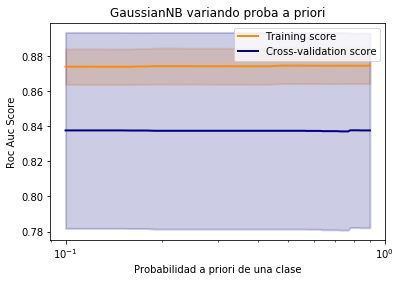

In [17]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve


    
def plot_validation_curveGAUSS(estimator, X, y, param, paramRange, plotTitle, parametroName):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param, param_range=paramRange,
        cv=5, scoring="roc_auc")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(plotTitle)
    plt.xlabel(parametroName)
    plt.ylabel("Roc Auc Score")
    lw = 2
    
    x = [i[0] for i in paramRange]
    
    plt.semilogx(x, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(x, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(x, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(x, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()


plot_validation_curveGAUSS(GaussianNB(),X_dev_np, y_dev_np, "priors", priors, "GaussianNB variando proba a priori","Probabilidad a priori de una clase") 

Obtenemos entonces que, al variar la probabilidad a priori de una clase desde 0.1 a 0.9, no obtenemos diferencia en el score.

Estos resultados nos hacen bastante ruido, ya que - en nuestra opinión - la probabilidad a priori debería afectar al modelo de manera directa.

Por tanto, Sklearn debe ignorar este parámetro, o de alguna manera evitar que una mala probabilidad a priori arruine el score.

## LinearSVC

In [18]:
parametros_lineal = {"C": [pow(10,x) for x in range(-15,5)]}
grid_lineal = GridSearchCV(LinearSVC(), parametros_lineal, cv=5, scoring="roc_auc")
time1 = time.time()
grid_lineal.fit(X_dev_np, y_dev_np)
time2 = time.time()
tiempo_linearSVC=(time2-time1)*1000.0
top_resultados_training(grid_lineal, top=5)
top_resultados(grid_lineal, top=5)

Top 5 combinaciones por entrenamiento


,C,mean_score_validation,mean_score_training
19,10000.0,0.7965,1.0
18,1000.0,0.7965,1.0
17,100.0,0.7965,1.0
16,10.0,0.7965,1.0
15,1.0,0.7977,1.0


Top 5 combinaciones por validación


,C,mean_score_validation,mean_score_training
12,1.0000e-03,0.8569,0.9632
11,1.0000e-04,0.8427,0.8849
10,1.0000e-05,0.8335,0.8567
9,1.0000e-06,0.8322,0.8529
7,1.0000e-08,0.8319,0.8526


**En cuanto a Linear SVC**, tenemos en cuenta que el factor C controla el grado de clasificación errónea de los datos de entrenamiento, mediante el tamaño del margen y la cantidad de puntos que se permiten sin respetar la clasificación del hiperplano. Cuando C es chico, el margen se agranda, con muchas observaciones sin respetar el margen propuesto. En este caso obtenemos un clasificador que 'fittea' más suavemente sobre los datos, con más sesgo y menos varianza. Cuando el parámetro C es grande, buscamos márgenes más finos, que casi no permite ser traspasado por alguna observación. Esto produce un clasificador con bajo sesgo pero alta varianza.

Nos resultó importante chequear empíricamente este análisis teórico de C, y se ve reflejado en los resultados obtenidos: Al ordenar por mejores resultados de training, resulta ser que un margen muy angosto funciona mucho mejor - a costa de cierto overfitting: tenemos un peor resultado de validación debido a la alta varianza antes mencionada. Mientras tanto, al ordenar por resultados de validación, resulta ser que un margen más grande funciona mejor: El sesgo de entrenamiento aumenta, pero la varianza es baja y no se overfittean los datos: el modelo está mucho más adaptado para evaluar correctamente a los nuevos datos de validación.

Finalmente notamos que en el caso de evaluar por datos de entrenamiento el modelo se queda con el C más grande y exagerado (10^5), mientras que por datos de validación se quedó con uno intermedio (10^-3).

# Ejercicio 3 extra:

Utilizamos RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizamos si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 


**Notamos un detalle importante:** Una ventaja de RandomizedSearch es que quizás prueba con valores que GridSearch no prueba. Esto ocurre cuando existe un par de valores con los que prueba gridSearch, tal que tengan un valor válido entre ellos con los que gridSearch no pruebe.
    
Por ejemplo, si GridSearch prueba con valores de a 10 para un hiperparámetro entero, probará con 10, 20, 30, etcétera; perdiéndose de probar con 24, que quizás resulte en mejor score.
    
Esto ocurrirá únicamente para ciertos parámetros de modelos. Para otros, no. Por lo tanto, para los casos en donde se pueda hacer, decidimos pasarle a RandomizedSearch los rangos de los parámetros con más granularidad que la utilizada en GridSearch, para permitirle a Randomized que pruebe con combinaciones que Grid no.

In [19]:
from sklearn.model_selection import RandomizedSearchCV


## Árbol de decisión

In [20]:
parametros_arbol = {"criterion":["entropy", "gini"], 'max_depth':np.arange(1,100)}
randomized_arbol = RandomizedSearchCV(DecisionTreeClassifier(), parametros_arbol, cv=5, scoring="roc_auc")
time1 = time.time()
randomized_arbol.fit(X_dev_np, y_dev_np)
time2 = time.time()
tiempo_arboles_rand=(time2-time1)*1000.0
top_resultados_training(randomized_arbol, top=5)
top_resultados(randomized_arbol, top=5)

Top 5 combinaciones por entrenamiento


,criterion,max_depth,mean_score_validation,mean_score_training
0,gini,34,0.6171,1.0
1,entropy,11,0.6344,1.0
2,gini,57,0.6213,1.0
3,entropy,15,0.6319,1.0
4,entropy,62,0.6389,1.0


Top 5 combinaciones por validación


,criterion,max_depth,mean_score_validation,mean_score_training
8,entropy,39,0.6515,1.0000
9,gini,1,0.6438,0.7246
4,entropy,62,0.6389,1.0000
1,entropy,11,0.6344,1.0000
3,entropy,15,0.6319,1.0000


In [21]:
data_tiempos = [["Grid", tiempo_arboles], ["Randomized", tiempo_arboles_rand]]
pd.DataFrame(data_tiempos, columns=["Search", "Tiempo de arboles de decisión (en ms)"])

,Search,Tiempo de arboles de decisión (en ms)
0,Grid,39953.4254
1,Randomized,1963.5866


En cuanto a árboles de decisión, gridSearch va a revisar todas las combinaciones de parámetros (criterio = gini/entropy, profundidad = [1..100]). Por lo tanto, los mejores resultados obtenidos, tanto evaluando por validación o entrenamiento, van a ser los mejores dentro de ese rango.

Por otro lado, RandomizedSearchCV tiene un parámtetro **n_iter**, el cual marca cuántas combinaciones de hiperparámetros se prueban, por lo cual se explora mucho menos: Como se ve en ambas tablas recién producidas, esto nos da una mejora en tiempos, pero empeora la calidad de los hiperparámetros encontrados.

Para comprobar esta teoría, probamos correr RandomizedSearchCV con **n_iter** = 200, el número de combinaciones totales que pueba GridSearchCV

In [22]:
parametros_arbol = {"criterion":["entropy", "gini"], 'max_depth':np.arange(1,100)}
randomized_arbol = RandomizedSearchCV(DecisionTreeClassifier(), parametros_arbol, cv=5, scoring="roc_auc", n_iter=198)
time1 = time.time()
randomized_arbol.fit(X_dev_np, y_dev_np)
time2 = time.time()
tiempo_arboles_rand=(time2-time1)*1000.0
top_resultados(randomized_arbol, top=5)

Top 5 combinaciones por validación


,criterion,max_depth,mean_score_validation,mean_score_training
100,gini,2,0.6958,0.8091
1,entropy,2,0.6933,0.8077
101,gini,3,0.6931,0.8868
2,entropy,3,0.6869,0.8855
102,gini,4,0.6783,0.9437


In [23]:
data_tiempos = [["Grid", tiempo_arboles], ["Randomized", tiempo_arboles_rand]]
pd.DataFrame(data_tiempos, columns=["Search", "Tiempo de arboles de decisión (en ms)"])

,Search,Tiempo de arboles de decisión (en ms)
0,Grid,39953.4254
1,Randomized,39988.7350


Vemos que los mejores modelos son los mismos que los producidos por GridSearchCV (o casi - debido a cierto factor de aleatoriedad).

Por último probamos correr RandomizedSearchCV con **n_iter** = 50, un cuarto de las iteraciones corridas por GridSearchCV, buscando optimizar el trade-off entre calidad de hiperparámetros y costo de la ejecución.

In [24]:
parametros_arbol = {"criterion":["entropy", "gini"], 'max_depth':np.arange(1,100)}
randomized_arbol = RandomizedSearchCV(DecisionTreeClassifier(), parametros_arbol, cv=5, scoring="roc_auc", n_iter=50)
time1 = time.time()
randomized_arbol.fit(X_dev_np, y_dev_np)
time2 = time.time()
tiempo_arboles_rand=(time2-time1)*1000.0
top_resultados(randomized_arbol, top=5)

Top 5 combinaciones por validación


,criterion,max_depth,mean_score_validation,mean_score_training
3,entropy,23,0.6692,1.0000
19,entropy,6,0.6640,0.9972
34,entropy,56,0.6598,1.0000
42,entropy,28,0.6525,1.0000
33,entropy,43,0.6487,1.0000


In [25]:
data_tiempos = [["Grid", tiempo_arboles], ["Randomized", tiempo_arboles_rand]]
pd.DataFrame(data_tiempos, columns=["Search", "Tiempo de arboles de decisión (en ms)"])

,Search,Tiempo de arboles de decisión (en ms)
0,Grid,39953.4254
1,Randomized,10286.6957


Obtenemos entonces un buen balance entre calidad del modelo y costo temporal, con un puntaje casi idéntico al del gridSearchCV y con costo temporal significativamente más bajo.

Notamos además, que RandomizedSearch no ofrece combinaciones que GridSearch no había analizado antes (porque las variables son discretas, y GridSearch ya recorre todos los elementos sus rangos).

## kNN

In [26]:
parametros_knn = {"weights":["uniform", "distance"], 'n_neighbors':np.arange(1,200)}
randomized_knn = RandomizedSearchCV(KNeighborsClassifier(), parametros_knn, cv=5, scoring="roc_auc", n_iter=10)
time1 = time.time()
randomized_knn.fit(X_dev_np, y_dev_np)
time2 = time.time()
tiempo_knn_rand=(time2-time1)*1000.0
top_resultados(randomized_knn, top=5)

Top 5 combinaciones por validación


,n_neighbors,weights,mean_score_validation,mean_score_training
6,38,uniform,0.8504,0.8637
2,44,distance,0.8492,1.0000
4,27,distance,0.8441,1.0000
7,29,uniform,0.8431,0.8630
8,27,uniform,0.8427,0.8616


In [27]:
data_tiempos = [["Grid", tiempo_knn], ["Randomized", tiempo_knn_rand]]
pd.DataFrame(data_tiempos, columns=["Search", "Tiempo de kNN (en ms)"])

,Search,Tiempo de kNN (en ms)
0,Grid,78723.3231
1,Randomized,1879.8745


En cuanto a kNN, el score de validación obtenido con RandomizedSearchCV con n_iter=10 es casi idéntico al de gridSearchCV (alrededor de 0.85), encima con una gran ventaja de costo temporal. Tenemos en cuenta, de todas maneras, que al ser 10 tan pocas combinaciones para probar, será muy variable la calidad del modelo obtenido (en nuestro caso, corriendo varias veces, resultó de una variabilidad de 0.4 en score).

Agregamos que, nuevamente, RandomizedSearch no ofrece combinaciones nuevas no descubiertas por GridSearch, por los motivos mencionados anteriormente.

## LDA

In [49]:
priors = list(zip(np.linspace(0.1,0.9,101),np.linspace(0.9,0.1,101)))
parametros_lda = {"solver":["lsqr", "eigen"], "priors":priors, "shrinkage":np.linspace(0.1,0.9,101)}
randomized_lda = RandomizedSearchCV(LinearDiscriminantAnalysis(), parametros_lda, cv=5, scoring="roc_auc")
time1 = time.time()
randomized_lda.fit(X_dev_np, y_dev_np)
time2 = time.time()
tiempo_lda_rand=(time2-time1)*1000.0
top_resultados(randomized_lda, top=10)


Top 10 combinaciones por validación


,priors,shrinkage,solver,mean_score_validation,mean_score_training
9,"(0.8119999999999999, 0.18800000000000006)",0.732,eigen,0.8558,0.9365
6,"(0.596, 0.404)",0.668,eigen,0.8555,0.9594
5,"(0.628, 0.372)",0.676,lsqr,0.8553,0.9578
4,"(0.22, 0.78)",0.828,lsqr,0.8520,0.9273
3,"(0.524, 0.47600000000000003)",0.500,lsqr,0.8502,0.9788
8,"(0.14800000000000002, 0.852)",0.812,eigen,0.8489,0.9222
0,"(0.316, 0.684)",0.428,lsqr,0.8469,0.9831
1,"(0.58, 0.42000000000000004)",0.284,lsqr,0.8307,0.9915
7,"(0.524, 0.47600000000000003)",0.204,eigen,0.8171,0.9952
2,"(0.508, 0.492)",0.188,eigen,0.8133,0.9957


In [29]:
priors = list(zip(np.linspace(0.1,0.9,101),np.linspace(0.9,0.1,101)))
parametros_lda = {"solver":["svd"], "priors":priors}
randomized_lda = RandomizedSearchCV(LinearDiscriminantAnalysis(), parametros_lda, cv=5, scoring="roc_auc")
time1 = time.time()
randomized_lda.fit(X_dev_np, y_dev_np)
time2 = time.time()
tiempo_lda_rand= tiempo_lda_rand + (time2-time1)*1000.0
top_resultados(randomized_lda, top=5)

Top 5 combinaciones por validación


,priors,solver,mean_score_validation,mean_score_training
0,"(0.604, 0.396)",svd,0.7331,0.9996
1,"(0.1, 0.9)",svd,0.7331,0.9996
2,"(0.30000000000000004, 0.7)",svd,0.7331,0.9996
3,"(0.45199999999999996, 0.548)",svd,0.7331,0.9996
4,"(0.492, 0.508)",svd,0.7331,0.9996


In [30]:
data_tiempos = [["Grid", tiempo_lda], ["Randomized", tiempo_lda_rand]]
pd.DataFrame(data_tiempos, columns=["Search", "Tiempo de LDA (en ms)"])

,Search,Tiempo de LDA (en ms)
0,Grid,36926.7418
1,Randomized,3268.3389


En cuanto a LDA, que tiene bastantes combinaciones para probar, obtenemos una muy buena mejoría en tiempos. Por otro lado, con solamente 10 combinaciones probadas para LSQR y Eigen, sumado a 10 combinaciones probadas para SVD, obtenemos resultados muy parecidos a los del GridSearchCV.

Vale la pena destacar que los shrinkages de mejor resultado difieren entre GridSearch y RandomizedSearch. Recordamos que, para que el GridSearch no tarde demasiado, nos vimos forzados a tomar sólamente 11 valores para Shrinkage entre 0.1 y 0.9 que están desparramados sobre el rango; mientras que RandomziedSearch toma 10 valores entre 101 que cubren todo el rango. Por lo tanto, GridSearch se pierde de muchos valores intermedios que quizás optimizaban mejor el algoritmo. O sea que **GridSearch sí se pierde de algunas combinaciones**, lo cual es una importante conclusión de este inciso. Destacamos igual que, a pesar de haberse perdido de combinaciones, no lo dejó atrás en cuanto a score.

## Correcciones RPT: El parametro Shrinkage

Aquí extendimos la exploración del RandomizedSearch en este parámetro. Los resultados se condicen con lo dicho anteriormente, si bien tiene un factor aleatorio, la mayoría de las corridas resultan con un top 5 en el cual los factores de shrinkage son todos mayores a 0.5, al menos. Dicho de otra manera, el RandomizedSearch también encuentra que debe darle más importancia a la matriz de covarianza estimada

## GaussianNB

In [31]:
priors = list(zip(np.linspace(0.1,0.9,810),np.linspace(0.9,0.1,810)))
parametros_gauss = {"priors":priors}
randomized_gauss = RandomizedSearchCV(GaussianNB(), parametros_gauss, cv=5, scoring="roc_auc")
time1 = time.time()
randomized_gauss.fit(X_dev_np, y_dev_np)
time2 = time.time()
tiempo_gaussianNB_rand=(time2-time1)*1000.0
top_resultados(randomized_gauss, top=5)

Top 5 combinaciones por validación


,priors,mean_score_validation,mean_score_training
5,"(0.8713226205191595, 0.12867737948084046)",0.8374,0.8744
0,"(0.4095179233621755, 0.5904820766378245)",0.8372,0.8741
3,"(0.40556242274412857, 0.5944375772558714)",0.8372,0.8741
4,"(0.46291718170580964, 0.5370828182941904)",0.8372,0.8743
8,"(0.4668726823238567, 0.5331273176761433)",0.8372,0.8745


In [32]:
data_tiempos = [["Grid", tiempo_gaussianNB], ["Randomized", tiempo_gaussianNB_rand]]
pd.DataFrame(data_tiempos, columns=["Search", "Tiempo de GaussianNB (en ms)"])

,Search,Tiempo de GaussianNB (en ms)
0,Grid,1814.8258
1,Randomized,189.5096


Para GaussianNB, la diferencia de tiempos también resulta ser grande, mientras que los scores son los mismos.

Randomized técnicamente sí se pierde de ciertas combinaciones, pero como ocurre el fenómeno ya descripto de los mismos scores a pesar de distintas probabilidades a priori, no hay diferencia en este sentido.

# LinearSVM

In [33]:
np.linspace(0.9,0.1,810)

parametros_svm = {"C": [pow(10,x) for x in np.linspace(-15,15,200)]}
randomized_svm = RandomizedSearchCV(LinearSVC(), parametros_svm, cv=5, scoring="roc_auc")
time1 = time.time()
randomized_svm.fit(X_dev_np, y_dev_np)
time2 = time.time()
tiempo_SVM_rand=(time2-time1)*1000.0
top_resultados(randomized_svm, top=5)

Top 5 combinaciones por validación


,C,mean_score_validation,mean_score_training
1,2.2219e-06,0.8324,0.8535
4,2.6738e-10,0.8319,0.8526
6,3.2176e-14,0.8319,0.8526
7,4.2970e-09,0.8319,0.8526
0,4.1987e-01,0.7984,1.0000


In [34]:
data_tiempos = [["Grid", tiempo_linearSVC], ["Randomized", tiempo_SVM_rand]]
pd.DataFrame(data_tiempos, columns=["Search", "Tiempo de LinearSVC (en ms)"])

,Search,Tiempo de LinearSVC (en ms)
0,Grid,1161.7258
1,Randomized,1005.0046


Para SVC, en lugar de probar con 30 valores entre 10^-15 y 10^15, probamos con 200. Esto nos da mucha más granularidad, pero corremos el riesgo de que, aleatoriamente, se pruebe el modelo sólo con valores que den mal.

El randomized da mejor en tiempos, pero no tanto (probamos con 10 valores en vez de 30). También Randomized prueba combinaciones que Grid no. Sin embargo, al haberle dado tanta granularidad, es muy variable la calidad de hiperparámetros que podremos obtener.

## Conclusiones ejercicio 3 extra:

Observamos que randomizedSearch sirve más cuando tenemos parámetros densos o muchas combinaciones de parámetros, lo cual no ocurre en Árboles de decisión, pero sí ocurre en LDA, por ejemplo.

También obtuvimos que GridSearch se pierde de varias combinaciones de datos que quizas RandomizedSearch sí revisa.

Además, RandomizedSearch da mucho mejor en tiempos mientras que no pierde demasiado en score contra GridSearch.

Sin embargo, RandomizedSearch puede tener mala suerte y quedarse con combinaciones que no son tan buenas.

Concluimos entonces que entre GridSearch y randomizedSearch no hay mejor y peor, sino que cada uno sirve para ocasiones distintas. Hay muchos trade-offs en juego: tiempos, cantidad de combinaciones que se quieren probar, combinaciones que seguramente quisiéramos probar, etcétera.

Otra perspectiva posible es que RandomizedSearch podría servir más para ir tanteando sobre los resultados, y GridSearch para hacer una búsqueda exhaustiva sobre el rango posible de los hiperparámetros

## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




In [35]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

def plot_learning_curve(estimator, title, X, y, cv=None):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Roc Auc Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


def plot_validation_curve(estimator, X, y, param, paramRange, plotTitle, parametroName):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param, param_range=paramRange,
        cv=5, scoring="roc_auc")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(plotTitle)
    plt.xlabel(parametroName)
    plt.ylabel("Roc Auc Score")
    lw = 2
    plt.semilogx(paramRange, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(paramRange, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(paramRange, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(paramRange, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

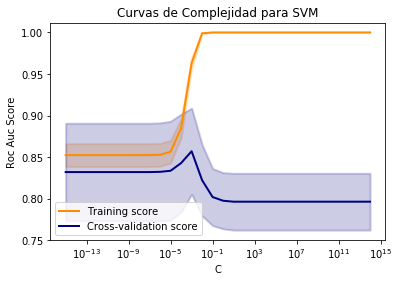

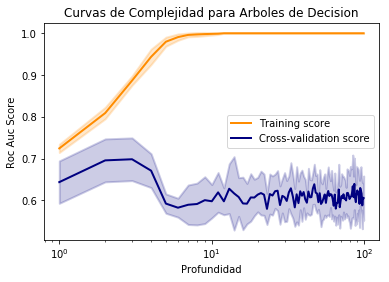

In [36]:
mejorSVM = grid_lineal.best_estimator_
mejorDecisionTree = grid_arbol.best_estimator_

plot_validation_curve(mejorSVM,X_dev_np, y_dev_np, "C", [pow(10,x) for x in range(-15,15)],
                      "Curvas de Complejidad para SVM", "C")
plot_validation_curve(mejorDecisionTree,X_dev_np, y_dev_np, "max_depth", range(1,100),
                      "Curvas de Complejidad para Arboles de Decision", "Profundidad")

# Analisis Curvas de Complejidad

## SVM
En el primer grafico podemos observar claramente qué es lo que varía en el modelo cuando cambiamos el hiperparámetro C para el modelo *SVM*. Al ser más chico permitis más clasificaciones erróneas cuando se determina el hiperplano. Esto logra tener una menor varianza pero un mayor sesgo, por lo que obtenemos un peor resultado de scoring. Luego vemos que se logra un pico en C=10^-3. Luego cuando vamos más allá de ese valor vemos que se reduce el sesgo pero aumentamos la varianza. Del grafico es muy fácil ver que el mejor estimador se obtiene con C=10^-3.

## Arboles de Decisión
En el segundo gráfico vemos lo mismo pero para *Árboles de Decisión*. Primero vemos como mejoran los resultados al aumentar la profundidad sin aumentar la varianza, luego llegamos a un pico en profundidad=50 y llegamos a un punto donde terminamos haciendo un marcado overfitting ya que aumentamos la distancia entre la performance de entrenamiento y de los datos de validacion, es decir, aumenta mucho la varianza.

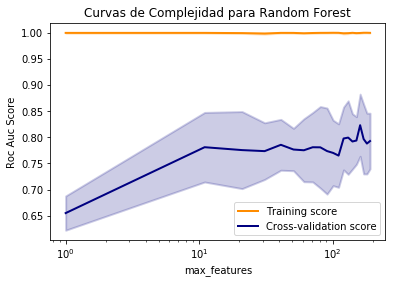

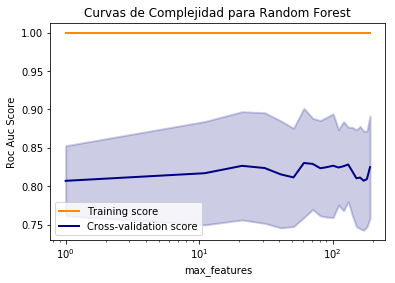

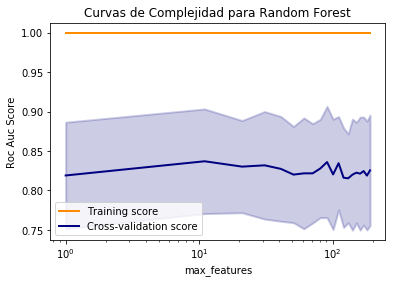

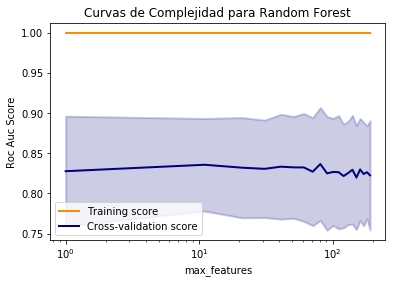

In [50]:
from sklearn.ensemble import RandomForestClassifier
plot_validation_curve(RandomForestClassifier(),X_dev_np, y_dev_np,
                      "max_features", range(1,201,10),
                      "Curvas de Complejidad para Random Forest", "max_features")

plot_validation_curve(RandomForestClassifier(n_estimators=50),X_dev_np, y_dev_np,
                      "max_features", range(1,201,10),
                      "Curvas de Complejidad para Random Forest", "max_features")

plot_validation_curve(RandomForestClassifier(n_estimators=100),X_dev_np, y_dev_np,
                      "max_features", range(1,201,10),
                      "Curvas de Complejidad para Random Forest", "max_features")

plot_validation_curve(RandomForestClassifier(n_estimators=200),X_dev_np, y_dev_np,
                      "max_features", range(1,201,10),
                      "Curvas de Complejidad para Random Forest", "max_features")

# Analisis Random Forest

### Curva de Complejidad
El hiperparametro max_features se encarga de limitar la cantidad de columnas o features a elegir en cada nodo del arbol sobre el cual hacer la seleccion del mejor corte. Mientras que cuando hacemos max_features = #features estamos implementando un modelo de Bagging, al reducirlo estamos haciendo que elija al azar un sample de los features para luego hacer el corte a partir de ésta selección. Los mejores numeros encontrados empíricamente para Random Forest han sido 

Al graficar la curva de complejidad notamos algo interesante, al poner un Random Forest con 200 árboles éste no ganaba mucho particularmente cuando se cambiaba la cantidad de features a elegir, no llamó la atención por lo cual decidimos graficar la curva de complejidad para varios valores de cantidad de arboles.

Lo que sucede al aumentar el n_estimators es interesante, a medida que llegamos a la cantidad de features cada vez importa menos el hiperparametro max_features. Creemos que esto se debe a que, al tener 200 árboles distintos haciendo la decisión, es posible que terminemos con un feature distinto en cada nodo ante la misma altura del arbol. Dicho de otra manera, no importa cuantos features le dejemos para elegir, cuando debe hacer 200 árboles distintos terminan siendo muy similares.

Por ultimo, cabe aclarar que cuando establecemos max_features en 200 obtenemos mejores resultados de performance.

In [ ]:
parametros_randomForest = {"n_estimators":[10, 50, 200],"max_features": ["sqrt", "log2", None]+ list(range(1,199, 50))}
grid_rf = GridSearchCV(RandomForestClassifier(), parametros_randomForest, cv=5, scoring="roc_auc")
grid_rf.fit(X_dev_np, y_dev_np)
top_resultados(grid_rf, top=10)

mejorRF = grid_rf.best_estimator_

plot_learning_curve(mejorRF, "Learning Curve Random Forest Mejor por GridSearch", X_dev_np, y_dev_np, cv=5)

# Analisis Random Forest
### Grid Search y Curvas de Aprendizaje

Al realizar el GridSearch obtenemos que los mejores hiperparámetros suelen ser sostenidamente max_features = log2 o sqrt y n_estimators=200, lo cual se condice con lo visto anteriormente ya que obtuvimos mejores resultados con 200 arboles y los picos de performance sucedian en estos valores.

Al graficar la curva de aprendizaje podemos ver una leve mejoría al aumentar la cantidad de features, por como es la curva sería interesante ver si se mantiene al menos hasta llegar a los 500 samples para ver si la mejoría se mantiene, al menos para ver si se llega al 0.8 de auc_roc.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

parametros_GB = {"learning_rate": np.linspace(0.1,1,100), "n_estimators": range(1,200)}
grid_GB = RandomizedSearchCV(GradientBoostingClassifier(), parametros_GB,n_iter=50,cv=5, scoring="roc_auc")
grid_GB.fit(X_dev_np, y_dev_np)
top_resultados(grid_GB, top=5)

mejorGB = grid_GB.best_estimator_

plot_learning_curve(mejorGB, "Learning Curve Gradient Boosting Mejor por RandomizedSearch", X_dev_np, y_dev_np, cv=5)

# Gradient Boosting vs. Random Forest

Al comparar estos dos modelos podemos ver que se comportan similarmente, si bien de todas maneras al utilizar el RandomizedSearch es posible que no estemos llegando a un maximo de performance, los resultados son muy similares al GridSearch de Random Forest en una fracción del tiempo. 

Sin embargo, a diferecia con Random Forest, podemos ver una más marcada curva positiva al aumentar la cantidad de features, esto nos lleva a pensar que Gradient Boosting sí se podría beneficiar de una mayor cantidad de samples en comparación con Random Forest.

## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.


In [ ]:
# Competencia
listaModelos = []
listaModelos.append(grid_arbol.best_estimator_)
listaModelos.append(grid_knn.best_estimator_)
listaModelos.append(grid_lda.best_estimator_)
listaModelos.append(grid_gauss.best_estimator_)
#listaModelos.append(grid_lineal.best_estimator_)
listaModelos.append(randomized_arbol.best_estimator_)
listaModelos.append(randomized_knn.best_estimator_)
listaModelos.append(randomized_lda.best_estimator_)
listaModelos.append(randomized_gauss.best_estimator_)
#listaModelos.append(randomized_svm.best_estimator_)
listaModelos.append(grid_rf.best_estimator_)
listaModelos.append(grid_GB.best_estimator_)

X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()
X_eval_np = np.array(X_eval)
y_eval_np = np.array(y_eval).ravel()


scoreMejorModelo = -1


for modelo in listaModelos:
    modelo.fit(X_dev_np, y_dev_np)
    y_pred_train = [y[1] for y in modelo.predict_proba(X_eval_np)]
    auc = sklearn.metrics.roc_auc_score(y_eval_np, y_pred_train)
    
    if auc > scoreMejorModelo:
        mejorModelo = modelo
        scoreMejorModelo = auc
        
print(mejorModelo)
print(scoreMejorModelo)
resultados = mejorModelo.predict_proba(X_competencia)

df = pd.DataFrame(index=range(501,5000))
df['output'] = [round(x[1],4) for x in resultados]
df.to_csv('y_competencia_RandomForrestGump.csv')

# Aclaraciones RTP sobre competencia

Tuvimos que comentar la evaluacion de los modelos basados en LinearSVC ya que carecian de la funcion predict_proba para realizar la curva ROC. Hemos visto que existen alternativas para calcular esto (el metodo decision_function y luego normalizarlo) pero creemos que se escapan a lo necesario para el trabajo, más que nada teniendo en cuenta que era para evaluar los modelos en vista de una competencia que ya sucedio, no solo eso hemos visto que consistentemente nuestro mejor modelo sigue siendo el de GradientBoosting

# Competencia

Agarramos los mejores modelos de cada GridSearch y RandomizedSearch y nos pusimos a buscar el modelo con mejor scoring en los datos que quedaron como held-out

Consistentemente el mejor modelo resultó ser GradientBoosting, con un learning_rate de aproximadamente 0.5. Si bien puede que al realizar repetidas corridas no sea siempre el mejor (por realizar un RandomizedSearch). Los resultados que se guardaron fueron los de este modelo

In [ ]:
from IPython.display import Image
Image("bubba.jpeg")